# Exploratory Data Analysis (EDA) of Google Health Searches#
Dataset is located at: https://www.kaggle.com/GoogleNewsLab/health-searches-us-county 
 * Make sure you have downloaded and unzipped the data first. 

There may be many reasons for searching a health condition on Google: an attempt to self-diagnose a health issue, receiving a new diagnosis from the doctor and looking for new ways to cope or treat a symptom, wanting to increase knowledge because a friend or relative is diagnosed, conducting research for a school project, writing a story, finding out more about a celebrity’s diagnosis. The list is endless, but there can still be value in finding large spikes of interest and knowing which health concerns are trending on the internet. Anomalies from the normal search interest scores could serve as an indicator of an epidemic or problem. For example, if there was a sudden jump in interest score for any query containing the word ‘virus’, health organizations could be alerted to investigate potential outbreaks in infectious diseases. The sooner that people become aware of a spreading infectious disease, the sooner that the disease can be contained. 

Another way that Google Health Searches could be useful is to identify areas of increasing health concern to communities. If a particular city continues to have high search interest over an extended period of time, community leaders and organizations could survey community members to see if further health education is needed. 

The Google Health Search Dataset contains data with a range of 0-100, and is described on Google Search API as an 'interest score'. Scores are proportional to the fraction of all searches, so a score of 100 represents very high interest, and a score of 50 is half as popular as the previous search. A score of 0 means that there was not enough data.

Caution must be used in interpreting this data; it is *not* possible to obtain the total count of searches because the scores are proportional. This means that a larger city with a score of 50 for a particular search such as 'cancer' would get a lower score than a smaller city where $\frac{3}{4}$ of searches were 'cancer' would get a score of 75. It is unclear from data source what the total search count is out of - is it of all Google searches, or just the searches that are in this dataset ('cancer', 'stroke', 'cardiovascular', 'diabetes', 'obesity', 'depression', 'vaccine', 'rehab', and 'diarrhea'). It is also ambiguous whether or not a search query such as 'diabetes' involves all variations of the query like 'Diabetes Type 1' or 'Diabetes Type 2', or does it strictly include queries with just the word 'diabetes'?

Because the data includes proportional health interest scores, the best way to use this data would be to look at relative increases and decreases in the interest scores. For example:
* Of the Google Health Search dataset, which health searches are the most and least popular?
* Are there any patterns in the regions which contain high outliers?
* Which health queries have the largest change in mean search interest score from year to year, and over the span of 2004-2017?
* Are there differences in interest score between the four U.S. regions (Northeast, South, West, Midwest)?

This way, even if there were a larger volume of searches in the most recent years because of increased internet use, the mean score should not be greatly affected  by the increased volume of users. Realistically though, the increased access to internet for different types of users (of various ages and wealth classes) will influence the outcomes, and should be considered when interpreting the data.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import zipfile
import io


This cell with open a window wher you can select the data csv file you downloaded.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving RegionalInterestByConditionOverTime.csv to RegionalInterestByConditionOverTime (2).csv
User uploaded file "RegionalInterestByConditionOverTime.csv" with length 85807 bytes


In [3]:
file='RegionalInterestByConditionOverTime.csv'
healthSearchData=pd.read_csv(file)
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,70,64,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,60,58,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,66,65,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,60,62,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,69,68,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78


In [0]:
# Check for null values

for col in healthSearchData.columns:
  bool_series = pd.isnull(healthSearchData[col])
  if len(healthSearchData[bool_series].index.values) != 0:
    print(healthSearchData[bool_series].index.values)

In [0]:
# Create a region column by extracting state, then map state to U.S. region
temp= [] # initialize empty list

for i in healthSearchData['dma']:
  temp.append(i[-2:]) # add last two letters of dma to temp list

healthSearchData['state_abbrev'] = temp # create new column 'state_abbrev'


In [6]:
# Fix index 11 state_abbrev, dma formatting different from other dma's
healthSearchData.set_value(11, 'state_abbrev', 'DC')
healthSearchData.iloc[11]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


dma                    Washington DC (Hagerstown MD)
geoCode                                          511
2004+cancer                                       47
2004+cardiovascular                                5
2004+stroke                                       15
                                   ...              
2017+vaccine                                      79
2017+diarrhea                                     55
2017+obesity                                      59
2017+diabetes                                     73
state_abbrev                                      DC
Name: 11, Length: 129, dtype: object

In [0]:
# Dictionary of state abbreviations to region ('West', 'Midwest', 'Northeast', 'South', and 'O' = other)

states = {
        'AK': 'West',
        'AL': 'South',
        'AR': 'South',
        'AS': 'O',
        'AZ': 'West',
        'CA': 'West',
        'CO': 'West',
        'CT': 'Northeast',
        'DC': 'South',
        'DE': 'Northeast',
        'FL': 'South',
        'GA': 'South',
        'GU': 'O',
        'HI': 'West',
        'IA': 'Midwest',
        'ID': 'West',
        'IL': 'Midwest',
        'IN': 'Midwest',
        'KS': 'Midwest',
        'KY': 'South',
        'LA': 'South',
        'MA': 'Northeast',
        'MD': 'South',
        'ME': 'Northeast',
        'MI': 'West',
        'MN': 'Midwest',
        'MO': 'Midwest',
        'MP': 'O',
        'MS': 'South',
        'MT': 'West',
        'NA': 'O',
        'NC': 'South',
        'ND': 'Midwest',
        'NE': 'Midwest',
        'NH': 'Northeast',
        'NJ': 'Northeast',
        'NM': 'West',
        'NV': 'West',
        'NY': 'Northeast',
        'OH': 'Midwest',
        'OK': 'South',
        'OR': 'West',
        'PA': 'Northeast',
        'PR': 'O',
        'RI': 'Northeast',
        'SC': 'South',
        'SD': 'Midwest',
        'TN': 'South',
        'TX': 'South',
        'UT': 'West',
        'VA': 'South',
        'VI': 'O',
        'VT': 'Northeast',
        'WA': 'West',
        'WI': 'Midwest',
        'WV': 'South',
        'WY': 'West'
}


In [0]:
# Create a column 'region' that maps state abbreviation to region
healthSearchData['region'] = healthSearchData['state_abbrev'].map(states)

In [9]:
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


In [0]:
# Drop the 'geoCode' column
healthSearchData = healthSearchData.drop('geoCode', axis=1)

In [11]:
healthSearchData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 129 entries, dma to region
dtypes: int64(126), object(3)
memory usage: 211.8+ KB


In [12]:
healthSearchData.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.0,43.0,47.0,100.0
2004+cardiovascular,210.0,7.433333,7.909647,0.0,5.0,6.0,9.0,100.0
2004+stroke,210.0,17.642857,8.135284,0.0,14.0,16.0,18.0,100.0
2004+depression,210.0,45.623810,13.715720,0.0,37.0,44.0,51.0,100.0
2004+rehab,210.0,18.890476,10.157723,0.0,15.0,17.0,21.0,100.0


# Boxplot and Swarmplot
The boxplot is useful for identifying outliers, but we can get more information from the swarmplots. Looking at all of the data as a swarmplot can help us to understand which region of the U.S. the outliers are coming from. 

In [0]:
# Create 'cancer' search dataframe with columns for year, count, region.  
years = []
cancer_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'cancer' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        cancer_all = pd.concat([cancer_all, add_col], axis=1)

# Rename columns with years only
cancer_all.columns = years

In [0]:
# Add 'region' column
cancer_all['region'] = healthSearchData['region']

In [0]:
# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(cancer_all, id_vars='region', var_name='year' )

Text(0, 0.5, 'Interest Score')

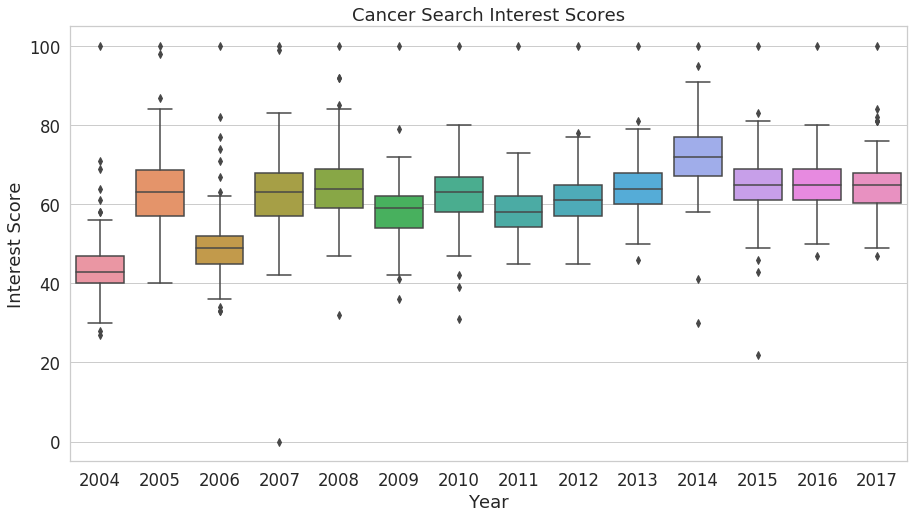

In [16]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# Box plot
fig = plt.gcf()
fig.set_size_inches(15, 8)
sns.boxplot("year", "value", data=melted_df)
plt.title('Cancer Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

Median search scores have not changed very much across the years. The boxplot shows how the median and outliers are changing by year, but is not very informative regarding which points are outliers. It would be nice to be able to tell which region the outlier is coming from? Which regions tends to have the highest search interest score?

In terms of general interest score for a search query of 'Cancer' over time, it appears that the score has been pretty steady with no large increase or decrease in this time frame.

Text(0, 0.5, 'Interest Score')

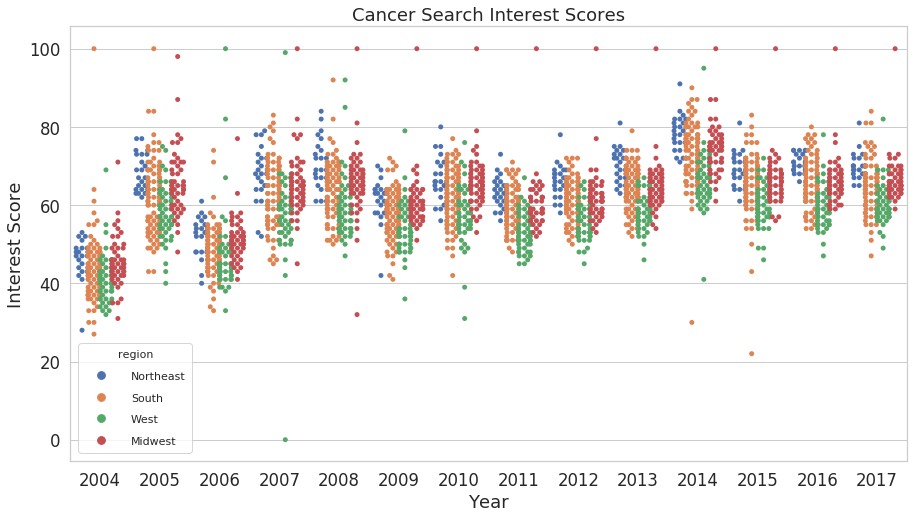

In [17]:
# Swarm plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Cancer Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

Now we can see which regions are getting scores of 0 or 100. High score of 100 are of particular interest because they represent unusually high interest, but scores of 0 are not important in this study since they represent a place where there was not enough data. 

It is quite interesting that the Midwest has had a interest score of 100 every year since 2007.


Text(0, 0.5, 'Interest Score')

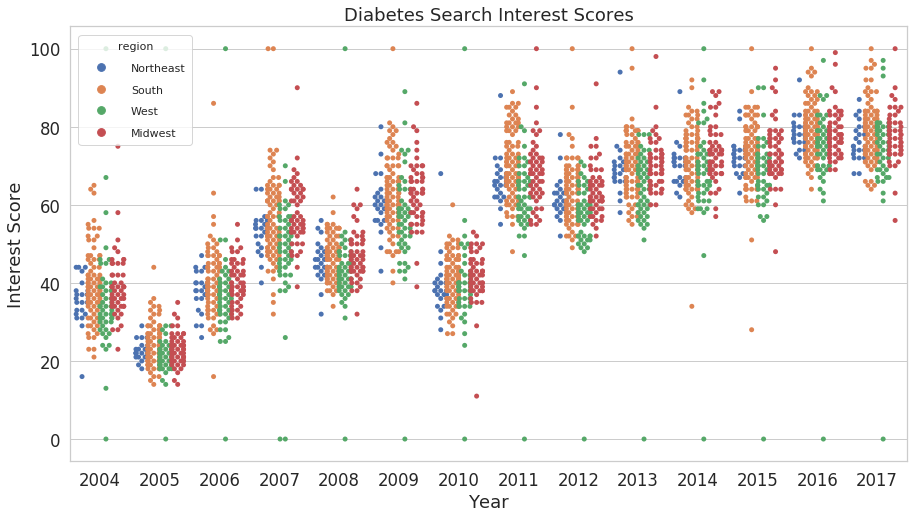

In [18]:
# Create 'diabetes' search dataframe with columns for year, count, region.  
years = []
db_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'diabetes' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        db_all = pd.concat([db_all, add_col], axis=1)

# Rename columns with years only
db_all.columns = years

# Create 'region' column
db_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(db_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Diabetes Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')


There is a lot more variability in the region with the outlying score of 100 in the diabetes search interest swarmplot when compared to the previous swarmplot for cancer search interest. The scores appear to increase a lot more over time when compared to the previous plot for cancer searches.

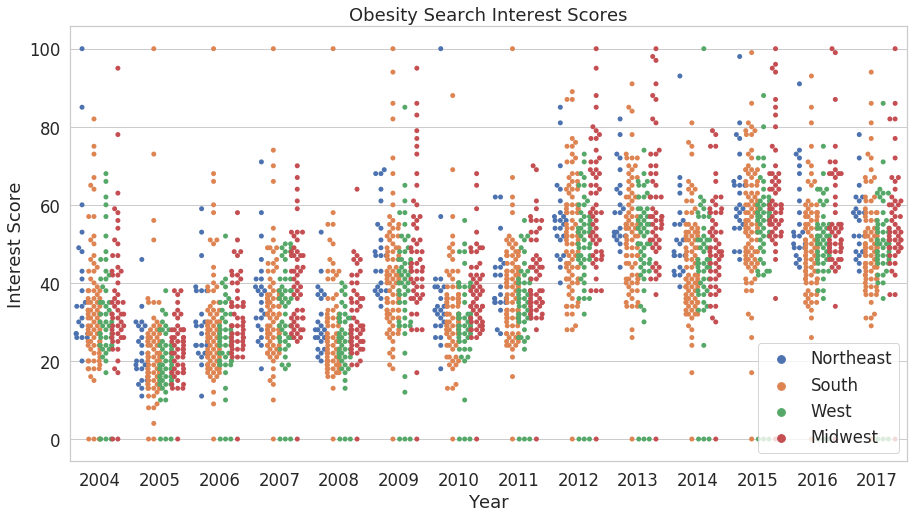

In [19]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# Create 'obesity' search dataframe with columns for year, count, region.  
years = []
obesity_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'obesity' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        obesity_all = pd.concat([obesity_all, add_col], axis=1)

# Rename columns with years only
obesity_all.columns = years

# Create 'region' column
obesity_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(obesity_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Obesity Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')
plt.legend(loc="lower right")

The scores of 100 come from various regions, with the majority coming from the South and Midwest. The search interest scores here are spread out and have a lot more variance within each region, compared to the previous plots for cancer and diabetes.

Text(0, 0.5, 'Interest Score')

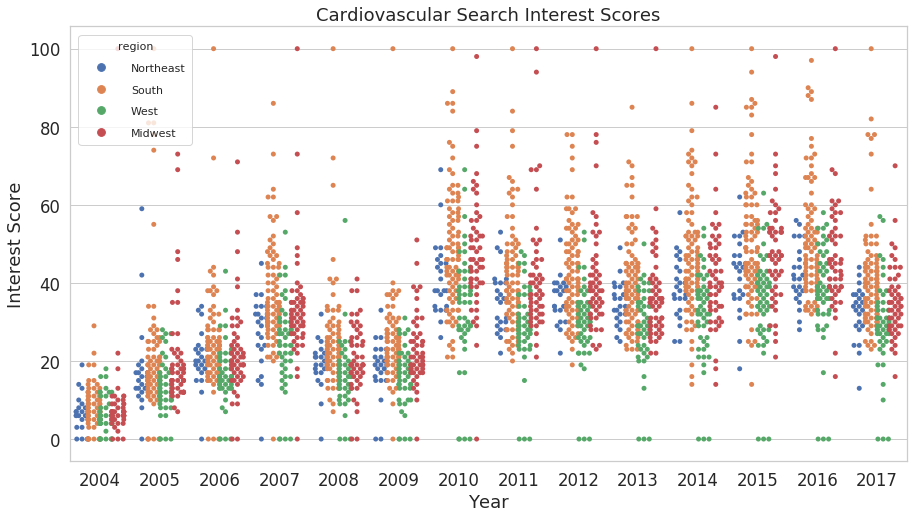

In [20]:
# Create 'cardiovascular' search dataframe with columns for year, count, region.  
years = []
cardio_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'cardiovascular' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        cardio_all = pd.concat([cardio_all, add_col], axis=1)

# Rename columns with years only
cardio_all.columns = years

# Create 'region' column
cardio_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(cardio_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Cardiovascular Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

The data has much larger variance than other queries, especially for the Midwest and South regions, where the outlying scores of 100 are also from. Interest scores have increased from 2004 to 2010, and appear pretty steady since 2010.

Text(0, 0.5, 'Interest Score')

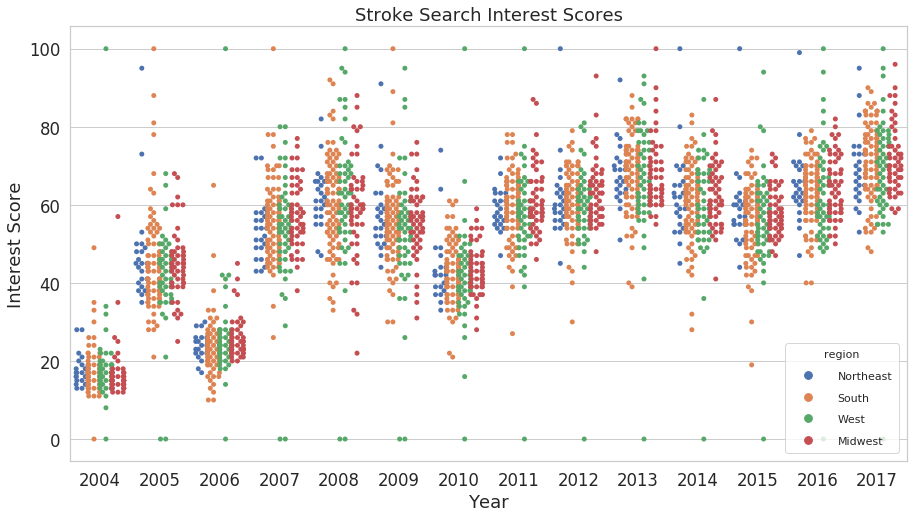

In [21]:
# Create 'stroke' search dataframe with columns for year, count, region.  
years = []
stroke_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'stroke' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        stroke_all = pd.concat([stroke_all, add_col], axis=1)

# Rename columns with years only
stroke_all.columns = years

# Create 'region' column
stroke_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(stroke_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Stroke Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

High outliers vary between the four regions in this timeframe. In most recent years, the high outliers are from the West and Northeast. There is some increase in search interest score for 'Stroke', but the increase appears to occur in 2004-2008, and then fluctuates around 60 after 2008.

Text(0, 0.5, 'Interest Score')

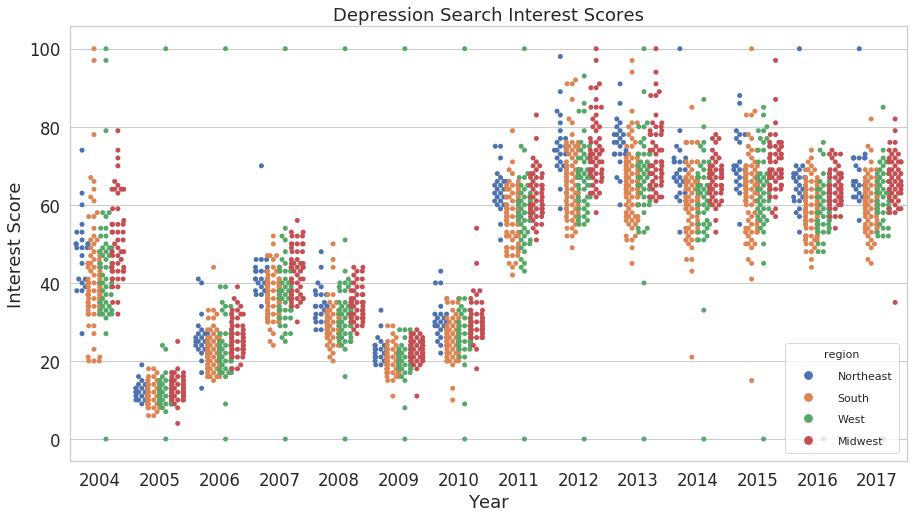

In [22]:
# Create 'depression' search dataframe with columns for year, count, region.  
years = []
dep_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'depression' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        dep_all = pd.concat([dep_all, add_col], axis=1)

# Rename columns with years only
dep_all.columns = years

# Create 'region' column
dep_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(dep_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Depression Search Interest Scores')
plt.xlabel('Year')
plt.ylabel('Interest Score')

Prior to 2012, high outliers are mostly from the West region. Following 2012, there is a mix of regions with high outliers. The trend in interest scores for depression is an unusual pattern with a large jump in the score from 2010 to 2011. 

# Mean Interest by Region

In computing the mean, all zero scores were removed from the dataset because a zero score does not represent very low interest. Zero scores were a result of not having enough data. As for scores of 100, they are kept in the analysis because they represent a very high search interest score. 

Rates of increase and decrease between years remained similar among regions for the most part. Given the varying lifestyles and weather of the four regions in the U.S., it was shocking that the mean interest scores did not vary much by region, which implies that the search interest varies grossly on a national rather than regional scale. 

Google search interest scores were extremely similar among the regions for diabetes and stroke, while there were differences between the regions cancer, obesity, cardiovascular, and depression.

In [0]:
# Remove zeros
healthSearchData_nozeros = healthSearchData.replace(0, np.nan)

In [24]:
healthSearchData_nozeros.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.00,43.0,47.0,100.0
2004+cardiovascular,184.0,8.483696,7.905159,2.0,5.00,7.0,10.0,100.0
2004+stroke,208.0,17.812500,7.986609,8.0,14.75,16.0,18.0,100.0
2004+depression,209.0,45.842105,13.377972,20.0,37.00,44.0,51.0,100.0
2004+rehab,202.0,19.638614,9.618757,6.0,15.00,18.0,21.0,100.0


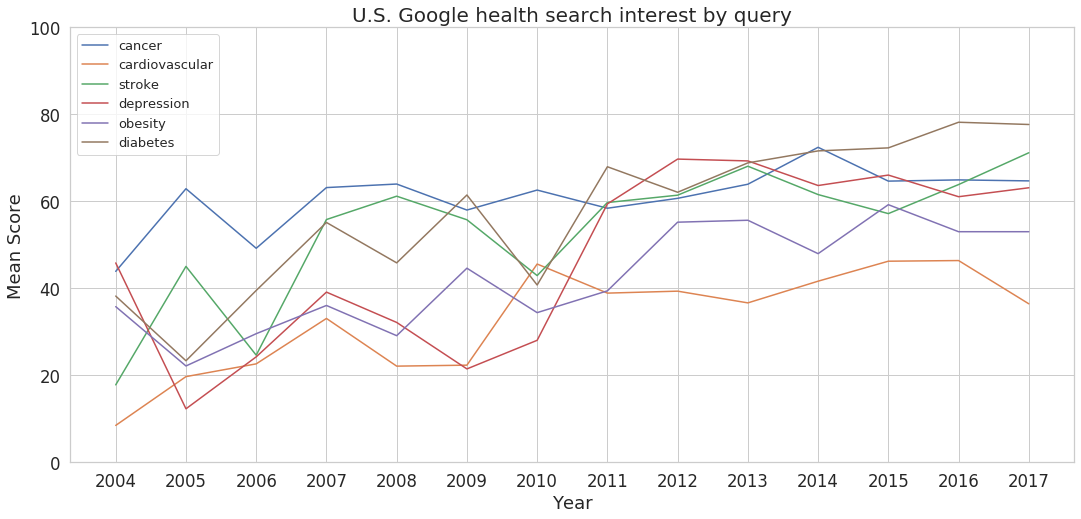

In [25]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# U.S. average for each query across years
yearMean = {}
for col in healthSearchData_nozeros.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in yearMean:
            yearMean[disease] = {}
        if not year in yearMean[disease]:
            yearMean[disease][year] = np.nanmean(list(healthSearchData_nozeros[col])) # take the mean ingnoring NaN's

# Remove unwanted keys
rem_list = ['diarrhea', 'rehab', 'vaccine']
[yearMean.pop(key) for key in rem_list]

plt.figure(figsize=(18, 8))
ax = plt.subplot(111)
plt.ylim(0,100)
plt.title("U.S. Google health search interest by query", fontsize=20)
plt.xlabel('Year')
plt.ylabel('Mean Score')

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(yearMean['cancer'].keys()))
lh = {} #dictionary with key = disease, and value = year mean
for disease in yearMean:
    tempList = list(yearMean[disease].values())
    lh[disease] = plt.plot(tempList)
plt.legend(lh, loc='best',  prop={'size': 13})


Of these health queries, diabetes had the highest mean search interest score from 2015-2017 and reached the highest mean interest score within this timeframe in 2017. Cancer starts off as being one of the most popular health searches from 2004-2010 and the interest scores remain relatively steady, but interest in diabetes, stroke and depression catch up in 2011. 
The least popular health search through most of the years was cardiovascular disease, although in 2005, 2009 and 2010 the query for depression had a lower mean search interest score than cardiovascular disease.


In [0]:
# Convert dictionary to dataframe
yearMeanDf = pd.DataFrame(yearMean)
yearMeanDf.reset_index(inplace=True)
yearMeanDf.rename(columns={'index':'Year'}, inplace=True)
#yearMeanDf.head(3)

In [0]:
# Melt dataframe to have only columns 'region', 'year', and 'value'; id_vars='region', var_name='year' 
melted = pd.melt(yearMeanDf, id_vars='Year', var_name='Query', value_name='Mean')
melted.Year = pd.to_numeric(melted.Year)
#melted.head()

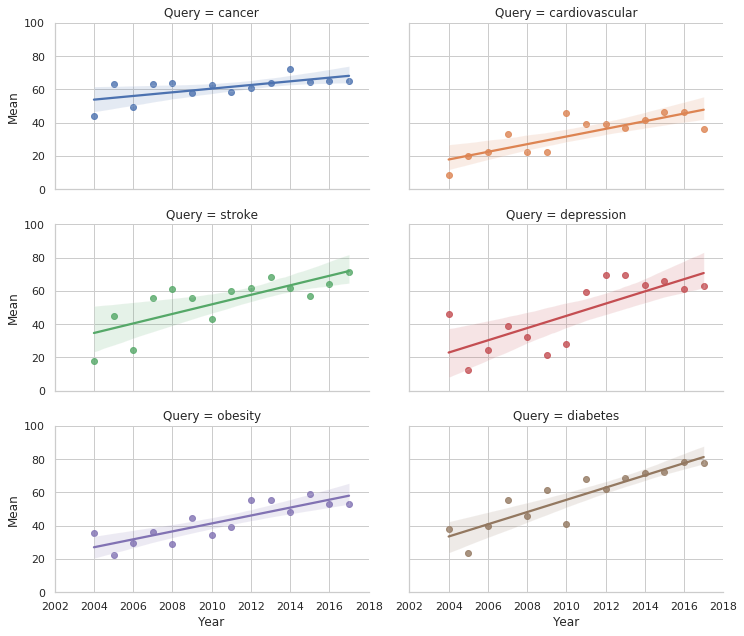

In [28]:
# Create subplots of mean interest score for each health query
sns.set(font_scale=1)
sns.set_style('whitegrid')
p = sns.lmplot(x='Year', y='Mean', hue='Query', data=melted,
            height=3, aspect=1.75, col_wrap=2, col='Query')

p.set(xlim = (2002,2018))
p.set(ylim = (0,100))
plt.tight_layout()


The line of best fit is plotted above for each of the health queries in order to visualize how quickly the mean search scores are increasing. While the mean search interest score for every query has increased, ‘diabetes’, ‘depression’ and ‘stroke’ have the highest rate of increase from 2004-2017 because their lines have the steepest slope. To verify this, a regression model can be fit to the data and then the rates of increase can be compared more accurately. 

However, it is an assumption that the mean search scores are linear. Different models should be tested to verify which model would be best for each data set. When considering year-to-year changes, search interest score for depression shows the greatest fluctuations and in fact, does not look linear. 
 


In [29]:
# Regional mean search count per city
region_mean = healthSearchData_nozeros.groupby('region').mean()
region_mean

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,45.588235,9.500000,16.980392,51.392157,17.755102,32.346939,18.549020,37.571429,39.156863,65.764706,20.647059,44.941176,13.078431,22.627451,28.160000,25.958333,23.560000,22.980392,51.274510,23.530612,25.568627,26.549020,30.549020,40.140000,44.940000,32.380000,40.235294,65.568627,34.440000,57.647059,43.117647,31.078431,44.235294,21.098039,41.060000,58.000000,65.764706,21.755102,59.274510,34.745098,...,64.254902,70.686275,61.300000,70.509804,74.490196,41.647059,62.725490,66.862745,55.941176,63.784314,70.647059,50.940000,73.333333,66.588235,48.039216,58.156863,70.254902,52.509804,65.352941,72.215686,63.860000,73.647059,66.235294,46.176471,64.705882,64.607843,44.823529,66.274510,75.058824,56.600000,78.490196,66.686275,35.294118,71.725490,66.568627,47.352941,74.784314,77.098039,56.600000,77.647059
Northeast,46.304348,7.800000,17.739130,48.347826,21.739130,42.409091,16.454545,39.826087,35.521739,68.391304,18.500000,47.304348,12.521739,25.782609,33.521739,27.409091,22.782609,22.565217,51.869565,21.590909,23.782609,25.826087,32.272727,44.521739,42.954545,30.652174,37.782609,67.956522,28.500000,53.565217,42.304348,37.826087,43.217391,20.695652,37.173913,53.173913,70.695652,20.045455,61.913043,34.739130,...,68.826087,68.217391,59.217391,69.217391,78.608696,38.695652,62.521739,69.347826,65.782609,66.869565,66.826087,52.173913,70.304348,69.217391,41.782609,59.260870,70.826087,61.782609,70.304348,71.913043,63.130435,72.521739,70.782609,42.086957,65.304348,65.565217,57.260870,68.434783,73.521739,57.608696,78.347826,70.043478,32.434783,69.391304,68.086957,58.826087,81.217391,73.000000,55.956522,76.347826
South,43.816092,8.693333,17.569767,42.298851,21.845238,32.674699,17.307692,34.190476,39.436782,62.517241,22.493827,45.390805,11.045977,28.246914,30.558140,27.700000,22.141176,24.080460,48.551724,25.083333,23.218391,22.206897,35.430233,37.376471,42.682353,29.209302,40.689655,63.229885,36.988372,55.793103,36.298851,38.413793,40.298851,21.546512,34.093023,56.747126,63.827586,25.344828,60.333333,29.494253,...,61.183908,69.965517,53.209302,69.942529,72.977011,46.701149,61.080460,60.747126,65.482759,58.954023,70.126437,45.372093,71.965517,65.034483,50.988506,56.080460,62.770115,61.954023,56.195402,70.000000,56.686047,73.172414,65.712644,51.241379,63.298851,58.827586,57.954023,59.287356,73.022989,50.395349,79.505747,64.551724,41.045977,71.712644,60.264368,60.712644,69.149425,73.080460,50.755814,79.091954
West,41.183673,7.243902,19.166667,45.166667,16.565217,34.565217,16.911111,34.800000,36.333333,58.061224,14.200000,43.425532,13.645833,20.595745,28.829787,24.717391,20.326087,22.791667,47.000000,17.600000,26.625000,24.750000,24.297872,38.382979,41.425532,26.673913,37.437500,58.229167,26.333333,55.000000,38.520833,30.000000,39.127660,18.191489,33.760870,50.085

In [0]:
# Find the mean number of searches per year for each region
# mean_dict dictionary, keys = disease, year

mean_dict = {}
for col in region_mean.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in mean_dict:
            mean_dict[disease] = {}
        if not year in mean_dict[disease]:
            mean_dict[disease][year] = region_mean[col]

In [31]:
print(mean_dict.keys())
print(mean_dict['cancer'].keys())
print(mean_dict['cancer']['2005'].keys())

dict_keys(['cancer', 'cardiovascular', 'stroke', 'depression', 'rehab', 'vaccine', 'diarrhea', 'obesity', 'diabetes'])
dict_keys(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
Index(['Midwest', 'Northeast', 'South', 'West'], dtype='object', name='region')


In [32]:
mean_dict['cancer']['2004'].values

array([45.58823529, 46.30434783, 43.81609195, 41.18367347])

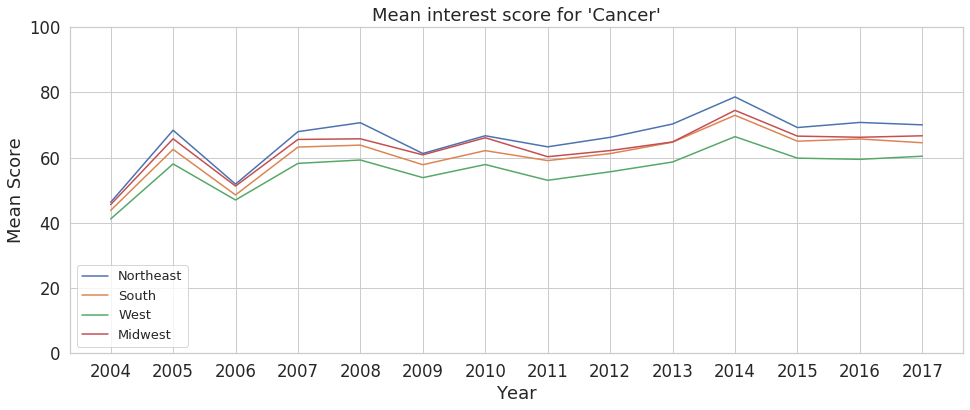

In [33]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

cancer_df = pd.DataFrame(mean_dict['cancer']).T
cancer_df = cancer_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(cancer_df)
plt.title("Mean interest score for 'Cancer'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(cancer_df.columns, fontsize=13, loc='lower left')


The line chart aisre interesting in that the rate of increases and decreases are pretty consistent across the regions. The four lines are spread out more moderately, and it is clear that the Northeast region has the highest mean search interest score and the West has the lowest mean search interest score. 

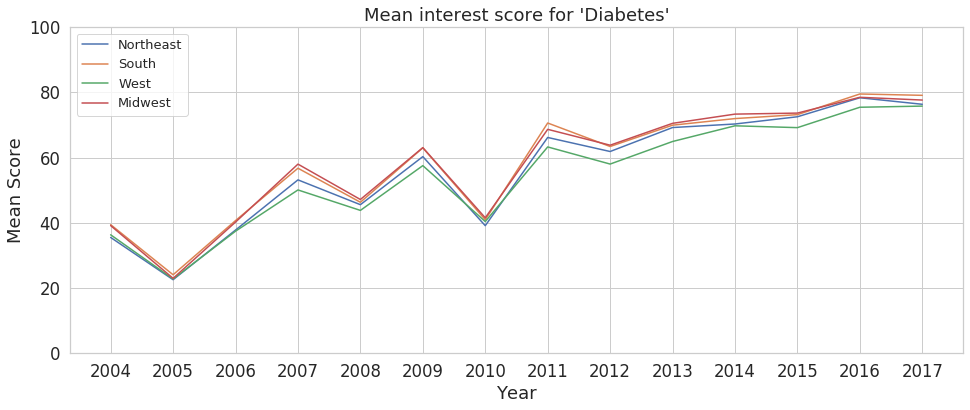

In [34]:
diabetes_df = pd.DataFrame(mean_dict['diabetes']).T
diabetes_df = diabetes_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(diabetes_df)
plt.title("Mean interest score for 'Diabetes'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(diabetes_df.columns, fontsize=13, loc='upper left')

The lines are bunched up quite tightly, so this means that there is low variance across regions for mean search interest score for diabetes. It is clear in the plot above that diabetes has increasingly been searched by people from all regions across the U.S. It would be interesting to compare this rate of increase to the number of people diagnosed with diabetes during this timeframe. Is there a relationship between the Google health search interest score and the prevalence of a disease? Knowing the strength of the relationship would help in determining how anomalies in the Google search interest could serve as a health indicator. 

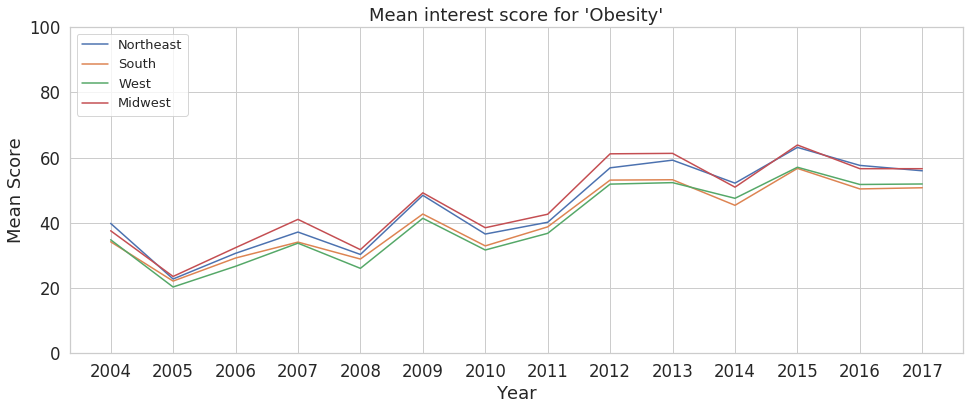

In [35]:
obesity_df = pd.DataFrame(mean_dict['obesity']).T
obesity_df = obesity_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(obesity_df)
plt.title("Mean interest score for 'Obesity'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(obesity_df.columns, fontsize=13, loc='upper left')

Small increase in obesity interest score over time. The mean interest scores for the Northeast and Midwest are consistently higher than the South and West regions.

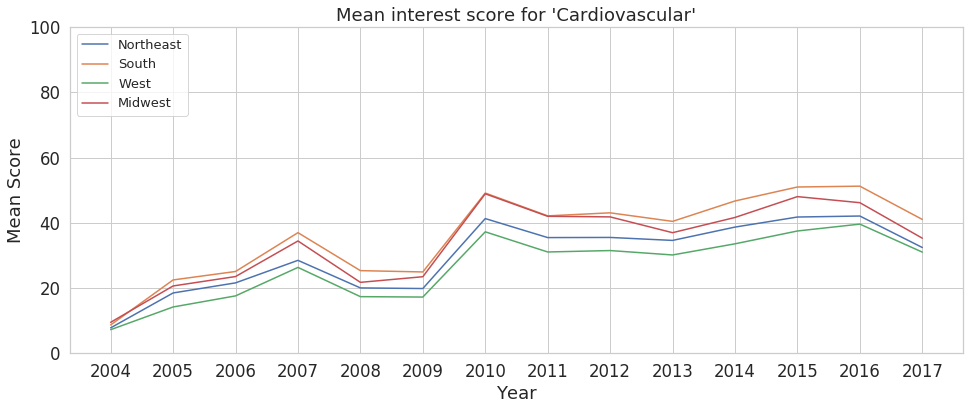

In [36]:
cardio_df = pd.DataFrame(mean_dict['cardiovascular']).T
cardio_df = cardio_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(cardio_df)
plt.title("Mean interest score for 'Cardiovascular'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(cardio_df.columns, fontsize=13, loc='upper left')

While there is a small increase in mean search interest score for cardiovascular disease, it is quite surprising that the mean search interest score is so low for cardiovascular diseases, being that cardiovascular disease has been one of the top health problems in the U.S. for years. The South region usually has the highest mean interest score, and is sometimes tied with the Midwest region. The West consistently has the lowest mean interest score throughout this timeframe.

Having diabetes is a large risk factor for getting heart (cardiovascular) disease. What is the correlation in interest score between diabetes and cardiovascular disease?

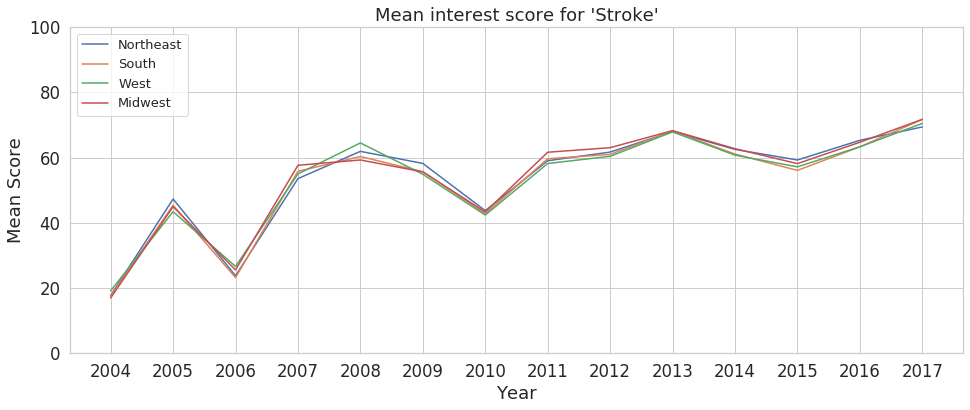

In [37]:
stroke_df = pd.DataFrame(mean_dict['stroke']).T
stroke_df = stroke_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(stroke_df)
plt.title("Mean interest score for 'Stroke'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(stroke_df.columns, fontsize=13, loc='upper left')

Very low variance in 'stroke' inte.rest scores among the regions. The search interest has increased since 2004, but has remained around 60 since 2007.

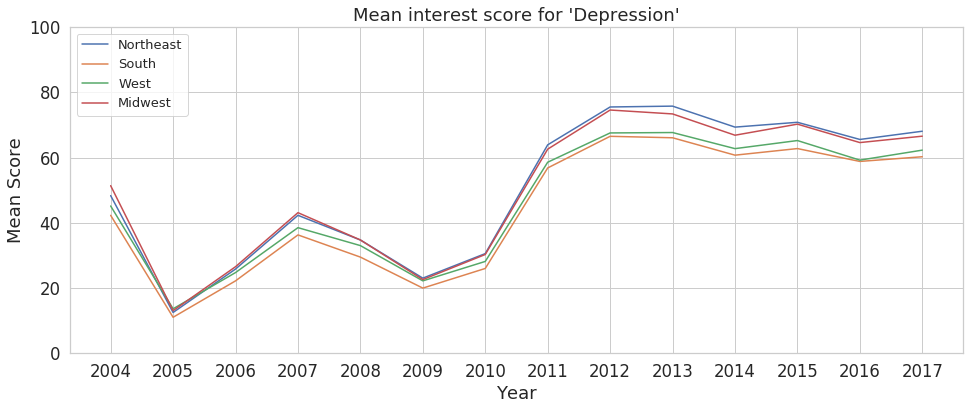

In [38]:
depr_df = pd.DataFrame(mean_dict['depression']).T
depr_df = depr_df[['Northeast', 'South', 'West', 'Midwest']]

plt.figure(figsize=(16, 6))
ax = plt.plot(depr_df)
plt.title("Mean interest score for 'Depression'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(depr_df.columns, fontsize=13, loc='upper left')


Interesting pattern compared to the previous line plots, very sharp increase from 2010 to 2012, followed by slighly decreasing scores since 2013. It would be interesting to see how interest in depression correlates to large national events, emergencies or the economy.


# Bar plots

The grouped bar plots allow us to clearly see which regions have the highest or lowest mean search interest scores.

In [0]:
cancer_df = pd.DataFrame(mean_dict['cancer']).T
cancer_df = cancer_df[['Northeast', 'South', 'West', 'Midwest']]

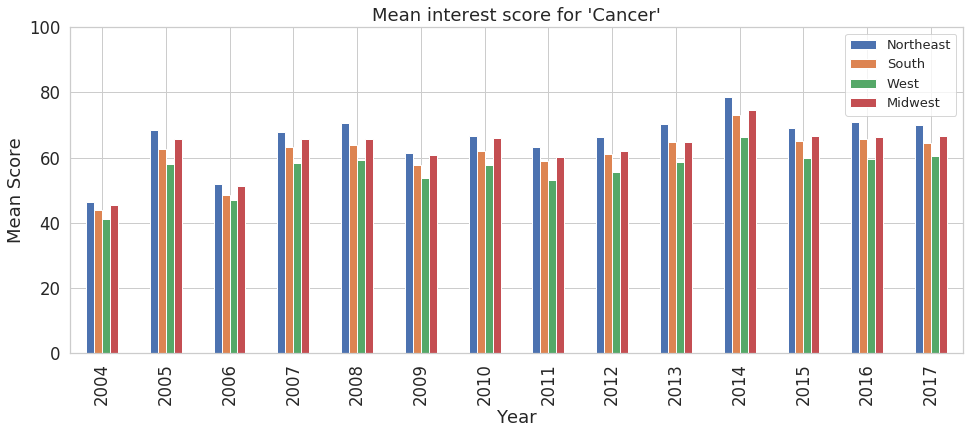

In [40]:
ax = cancer_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Cancer'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

The grouped bar charts are a nice way to compare the differences in mean search scores between regions. Here, we can tell that the Northeast consistently has a slightly higher interest score than the other regions, and the Western region has a slightly lower mean score.

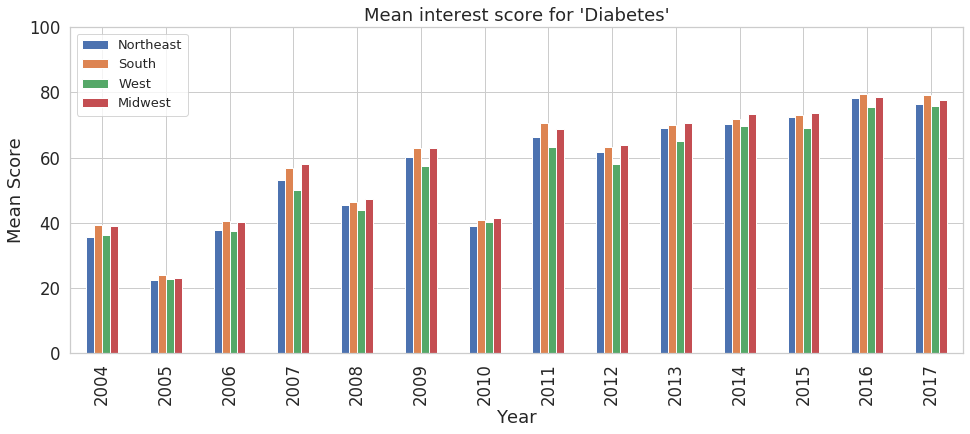

In [41]:
diabetes_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Diabetes'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

The difference between the mean interest score for the four regions is relatively small, with less than 10 points difference between the highest and lowest mean interest score for any given year.

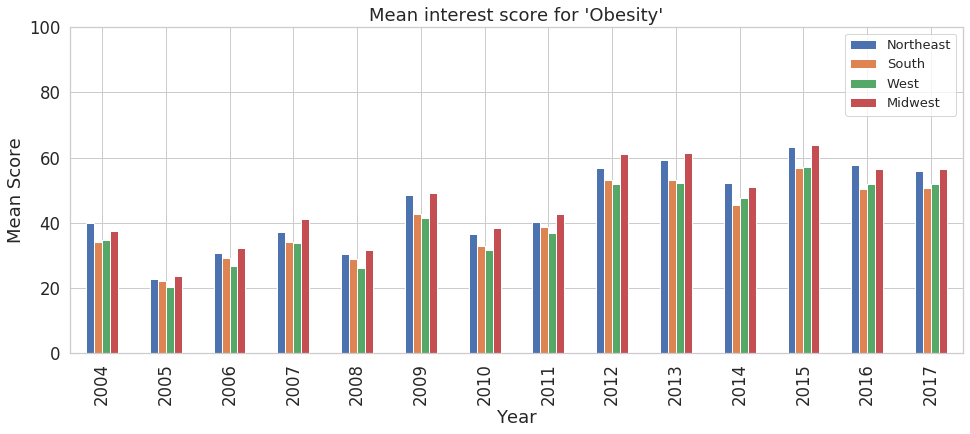

In [42]:
obesity_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Obesity'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

The Northeast and Midwest regions have higher mean search interest scores than the South and West region, but the difference between high and low scores appear pretty small.

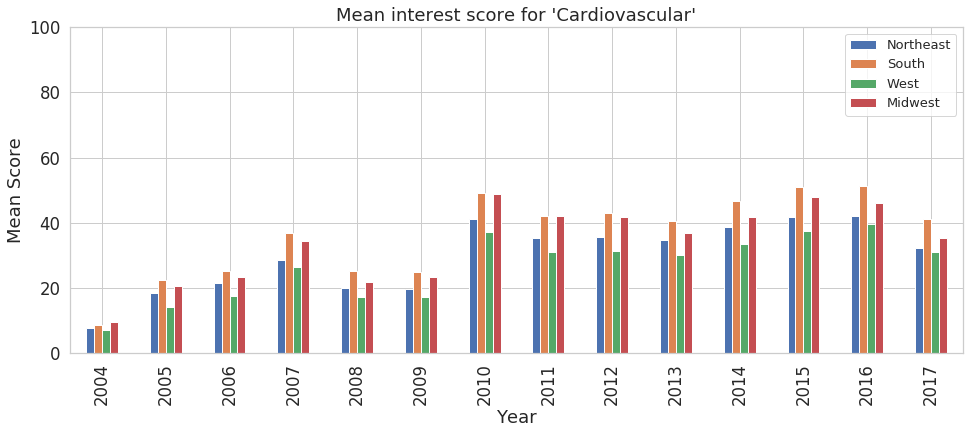

In [43]:
cardio_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Cardiovascular'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

The South and Midwest consistently have the highest mean interest score, adn the West has the lowest mean interest score. 

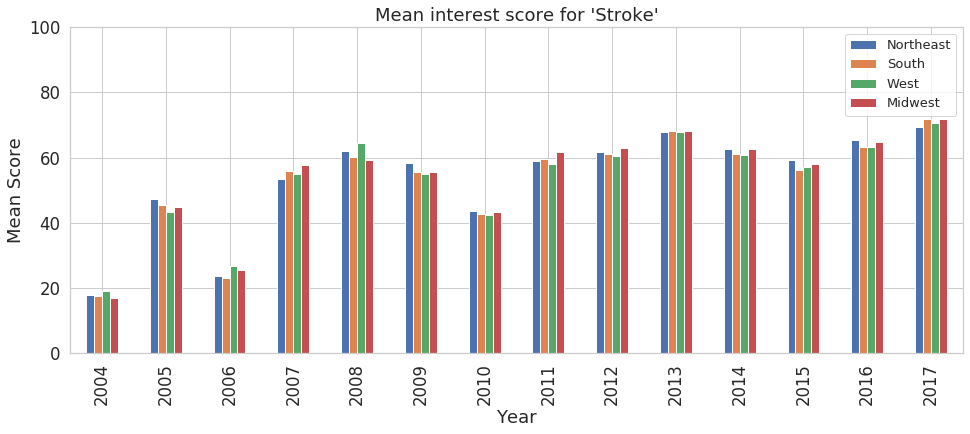

In [44]:
stroke_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Stroke'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

There does not appear to be any difference between the regions when it comes to the mean search interest score for stroke.

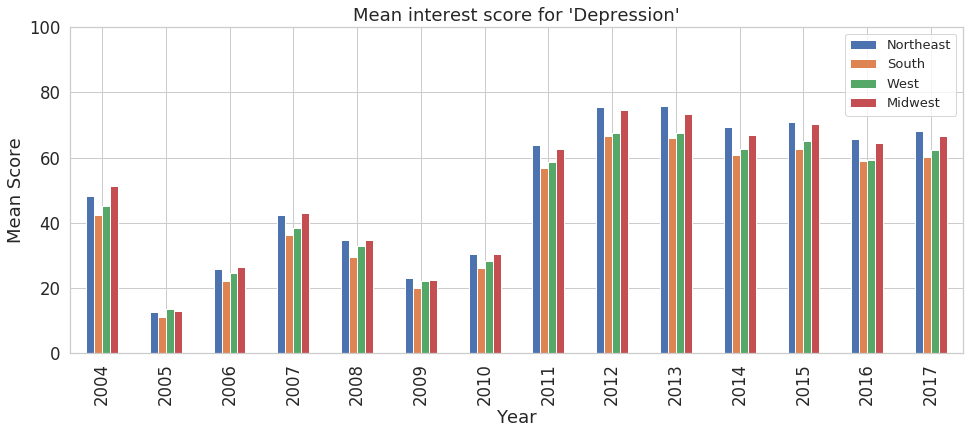

In [45]:
depr_df.plot(kind='bar', figsize=(16,6))
plt.title("Mean interest score for 'Depression'")
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(fontsize=13)

The Northeast and Midwest consistently have the highest mean interest score for depression. 

# Summary



* *Question 1: Of the Google Health Search dataset, which health searches are the most and least popular?*

Of these health queries, diabetes had the highest mean search interest score from 2015-2017 and reached the highest mean interest score within this timeframe in 2017. Cancer starts off as being one of the most popular health searches from 2004-2010 and the interest scores remain relatively steady, but interest in diabetes, stroke and depression catch up in 2011. 
The least popular health search through most of the years was cardiovascular disease, although in 2005, 2009 and 2010 the query for depression had a lower mean search interest score than cardiovascular disease.

* *Question 2: Are there any patterns in the regions which contain high outliers?*

The Midwest region had many interest scores of 100 over the years for cancer. The South and Midwest regions had many interest scores of 100 for cardiovascular disease. The high outliers for the other health queries were from a mix of regions.

* *Question 3: Which health queries have the largest change in mean search interest score from year to year, and over the span of 2004-2017?*

While all queries appear to have increased, diabetes, depression and stroke have the highest rate of increase from 2004-2017 because their lines have the steepest slope. To verify this, a regression model can be fit to the data and then the rates of increase can be compared more accurately. 

However, it is an assumption that the mean search scores are linear. Different models should be tested to verify which model would be best for each data set. When considering year-to-year changes, search interest score for depression shows the greatest fluctuations and in fact, does not appear linear. 


* *Question 4: Are there differences in interest score between the four U.S. regions (Northeast, South, West, Midwest)?*

It was surprising to see that the mean Google search interest scores were extremely similar among the regions for diabetes and stroke. Differences between the regions were observed for cancer, obesity, cardiovascular, and depression but the rates of increase and decrease between years remained similar among regions.

# Capstone Goals

Further analysis must be done to find the correlation between health search interest and the incidence of health diagnoses. Through this analysis, I found that there are small differences in interest scores between regions for certain health queries. It is important to know if these small differences in interest scores are correlated to actual differences in health by region. The null hypothesis will be that there is no correlation between health search interest score and disease incidence. 

If there is a strong correlation between high disease incidence and high search interest score, this could be an indicator that a particular location might have a need for more community health education. 

Another goal of this capstone will be to model the Google Health Search Data to see if a model can be created to predict mean search interest scores. There is great potential for this data to help us to identify health problems, not only in the U.S. but internationally since Google Search is used worldwide. 